In [1]:
'''
Данный код решает скалярное линейное уравнение переноса -- самую простую модель сплошной среды,
которая подчиняется уравнению в частных производных U_t + vel * U_x = 0, 
где vel - постоянная скорость потока (например, массы)
несмотря на простоту модели, данная задача уже может указать на большинство проблем, 
которые могут встретиться при численном моделировании самых разных сплошных сред.
Точное решение уравнения известно -- профиль, задаваемый начальным условием, сдвинется на расстояние 
S = time * vel за время time без какого-либо изменения
'''
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output  # добавляем импорт clear_output и display
import time

In [2]:
'''
#для использования метода конечного объема зададим одномерную сетку на призме единичного сечения 
#     +-----+-----+-----+-----+-----+-----+-----+-----+
#    /  1  /     /     /     /     /     /     /     /|
#   /     /     /     /     /     /     /     /     / |
#  +-----+-----+-----+-----+-----+-----+-----+-----+  |
#  | 1   |     |     |     |     |     |     |     |  |
#  |     |     |     |     |     |     |     |     |  +
#  |     |     |     |     |     |     |     |     | /
#  |     |     |     |     |     |     |     |     |/
#  +--dx-+-----+-----+-----+-----+-----+-----+-----+
'''

def grid_setup(xmin, xmax, Nx):
    #наша расчетная область - это призма с объемом x1*x2*x3 = (x1max - x1min)*1*1, которую мы "нарезаем" вдоль x1
    #количество фиктивных ("ghost") ячеек
    Ngc = 2
    #разрешение сетки dx1
    dx = (xmax - xmin)/Nx
    #задаем площадь грани и объем ячейки: fSurf = 1*1, сVol = 1*1*dx1
    fSurf = 1.0
    cVol = dx
    #координата центра ячейки
    cx = np.linspace(xmin - (Ngc - 0.5) * dx, xmax + (Ngc - 0.5) * dx, Nx + 2 * Ngc, dtype=np.double)
    #координата грани ячейки
    fx = np.linspace(xmin - Ngc * dx, xmax + Ngc * dx, Nx + 2 * Ngc + 1, dtype=np.double)

    return Ngc, dx, fSurf, cVol, cx, fx

In [3]:
'''
зададим решение в момент времени time (setup = 'disc' имитирует ударную волну/контактный разрыв в газе, 
a setup = 'smooth' имитирует гладкое течение в газе)
'''
def solution(xmin, xmax, cx, Nx, Ngc, time, setup):

    #зададим фоновую скорость потока
    vel = -1.0

    Len = xmax - xmin
    
    if setup == 'disc':
        
        #зададим исходные координаты разрыва
        x0_1 = 0.2
        x0_2 = 0.4
        
        #предполагаем что наша область периодическая, 
        #т.е. вещество, что выходит с одной стороны, сразу входит в область с другой стороны с сохранением параметров
        x_1 = x0_1 + vel * time - np.floor((x0_1 + vel * time)/Len) * Len
        x_2 = x0_2 + vel * time - np.floor((x0_2 + vel * time)/Len) * Len
    
        #задаем массив начальных данных в реальных ячейках
        for i in range(Ngc, Nx + Ngc):
            if x_2 > x_1:
                if cx[i] < x_1:
                    U0[i] = 1.0
                elif cx[i] < x_2:
                    U0[i] = 2.0
                else:
                    U0[i] = 1.0    
            else:
                U0[i] = 1.0
                if cx[i] <= x_2:
                    U0[i] = 2.0
                if cx[i] > x_1:
                    U0[i] = 2.0
                    
    elif setup == 'smooth':
        
        #начальная координата гладкого профиля
        x0 = 0.3
        
        #зададим исходную толщину профиля
        delta = 0.1
    
        #предполагаем что наша область периодическая, 
        #т.е. вещество, что выходит с одной стороны, сразу входит в область с другой стороны с сохранением параметров
        x = x0 + vel * time - np.floor((x0 + vel * time)/Len) * Len
    
        #задаем массив начальных данных в реальных ячейках
        for i in range(Ngc, Nx + Ngc):
            U0[i] = np.exp(-(cx[i] - x)**2/delta**2) + np.exp(-(cx[i] - x - np.sign(vel) * Len)**2/delta**2)

    
    #возвращаем решение во время time
    return U0, vel

In [4]:
'''
ограничитель наклона для схем со вторым порядком точности 
обеспечивает монотонность решения вблизи разрывов без ухудшения его качества в областях гладкости
-- не вносит в решение нефизичного осцилляторного поведения
'''
def limiter_func(x, y):

    #smoothness analyzer 
    r = (y + 1e-14) / (x + 1e-14)
    
    #van Leer limiter  function
    xy = x * (np.abs(r) + r) / (1.0 + np.abs(r))
    
    return xy

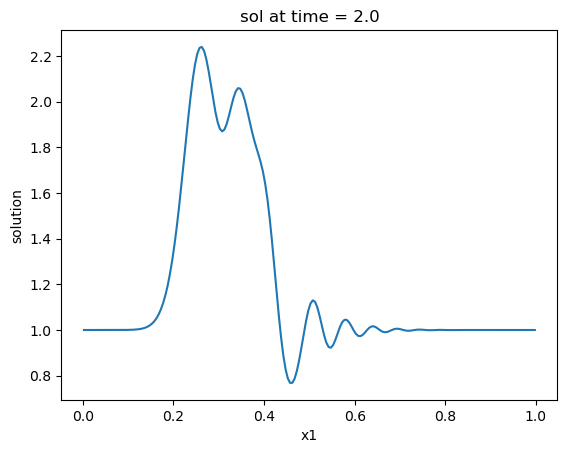

end of simulation


In [6]:
'''
#здесь начинается основной код программы
#-------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------
'''
#задаем нашу сетку - координаты границ и число ячеек
xmin = 0.0
xmax = 1.0
Nx = 200
Ngc, dx, fSurf, cVol, cx, fx = grid_setup(xmin,xmax,Nx)

#инициализируем массивы решения U0 (текущий шаг по времени) и U1 (следующий шаг по времени), а также точное решение Ua
U0 = np.zeros(Nx + Ngc * 2, dtype=np.double)
U1 = np.zeros(Nx + Ngc * 2, dtype=np.double)
Ua = np.zeros(Nx + Ngc * 2, dtype=np.double)

#инициализируем массив потоков в реальных гранях
flux = np.zeros(Nx+1, dtype=np.double)
print(np.size(flux))
print(Nx)
#зададим параметр Куранта-Фридрихса-Леви
CFL = 0.5


#зададим вид начального условия
setup = 'disc'

#зададим начальные условия для времени time = 0, а также финальное время time_fin
U0, vel = solution(xmin, xmax, cx, Nx, Ngc, 0.0, setup)
time_fin = 2.0

#задаем начальное время равным нулю
time = 0.0
#задаем начальное число шагов
nts = 0

#если не работает ipython - можно поставить runtimeplot = 0
runtimeplot = 1
if runtimeplot == 1:
    # Создание фигуры для графика
    fig, ax = plt.subplots()
    line, = ax.plot(cx[Ngc:-Ngc], U0[Ngc:-Ngc])
    ax.set_title('sol at time = ' + str(np.round(time, 2)))
    ax.set_xlabel('x1')
    ax.set_ylabel('solution')
    plt.close()  # Закрываем фигуру, чтобы она не отображалась сразу


#цикл по времени
while time < time_fin - 1e-14:
    
    #задаем шаг по времени 
    dt = min(CFL * dx / np.abs(vel), time_fin - time)
    time += dt
    nts += 1

    #задаем граничные условия с использованием фиктивных ячеек (в данном примере они периодические)
    for i in range(0,Ngc):
        #внутренняя граница
        U0[i] = U0[Nx+i]
        #внешняя граница
        U0[Nx+Ngc+i] = U0[Ngc+i]
    
    #записываем разные виды потока

    #поток от величины слева 
    #flux = vel * U0[Ngc-1:Nx+Ngc]
    
    #поток от величины справа 
    #flux = vel * U0[Ngc:Nx+Ngc+1]
    
    #полусумма из двух соседних ячеек
    #flux = vel * (U0[Ngc-1:Nx+Ngc] + U0[Ngc:Nx+Ngc+1])/2.0
    
    #поток из задачи Римана (cхема с первым порядком по времени и пространству)
    #flux = vel * (U0[Ngc-1:Nx+Ngc] + U0[Ngc:Nx+Ngc+1])/2.0 + np.abs(vel) * (U0[Ngc-1:Nx+Ngc] - U0[Ngc:Nx+Ngc+1])/2.0
    
    #Схема Лакса-Вендроффа (второй порядок по времени и пространству)
    flux = vel * (U0[Ngc-1:Nx+Ngc] + U0[Ngc:Nx+Ngc+1])/2.0 + vel * (vel * dt / dx) * (U0[Ngc-1:Nx+Ngc] - U0[Ngc:Nx+Ngc+1])/2.0
    
    #схема с ограничителем наклона (второй порядок по времени и пространству везде кроме областей с экстремумами/разрывами/сильными градиентами)
    #Ul = U0[Ngc-1:Nx+Ngc] + 1.0/2.0 * (1.0 - vel*dt/dx) * limiter_func(U0[Ngc-1:Nx+Ngc] - U0[Ngc-2:Nx+Ngc-1], U0[Ngc:Nx+Ngc+1] - U0[Ngc-1:Nx+Ngc])
    #Ur = U0[Ngc:Nx+Ngc+1] - 1.0/2.0 * (1.0 + vel*dt/dx) * limiter_func(U0[Ngc:Nx+Ngc+1] - U0[Ngc-1:Nx+Ngc], U0[Ngc+1:Nx+Ngc+2] - U0[Ngc:Nx+Ngc+1])
    #flux = vel * (Ul + Ur) / 2.0 + np.abs(vel) * (Ul - Ur) / 2.0
    
    #обновляем наше численное решение
    U1[Ngc:-Ngc] = U0[Ngc:-Ngc] - dt * ( flux[1:] * fSurf - flux[:-1] * fSurf ) / cVol
    
    #перезаписываем наше численное решение для использования на следующем шаге по времени (в итоге мы храним только два решения, а не все слои по t)
    U0[Ngc:-Ngc] = U1[Ngc:-Ngc]

    if ((nts%20 == 0 or time > time_fin - 1e-13) & (runtimeplot == 1)):
        line.set_data(cx[Ngc:-Ngc], U1[Ngc:-Ngc])
        ax.set_title('sol at time = '+ str(np.round(time, 2)))
        
        # Автоматическое масштабирование осей
        ax.relim()
        ax.autoscale_view()
        
        clear_output(wait=True)
        # Обновление графика с задержкой
        plt.pause(0.1)
        display(fig)


plt.ioff()
plt.show()

print('end of simulation')

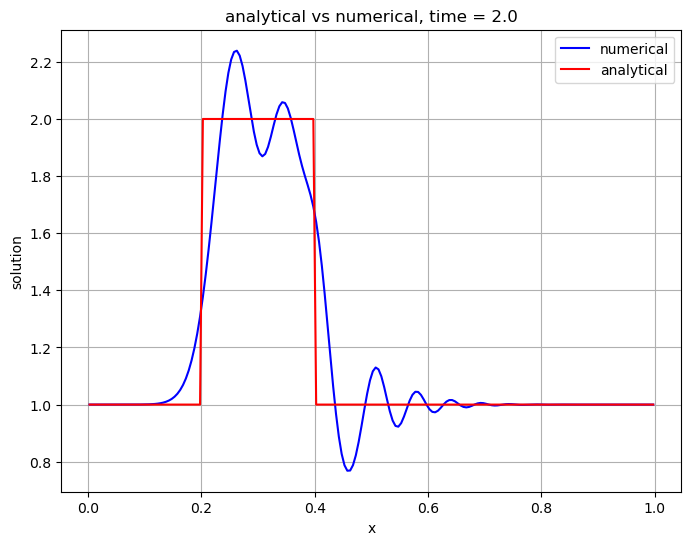

In [7]:
#точное решение 
Ua, vel = solution(xmin, xmax, cx, Nx, Ngc, time, setup)


# Создаем новый график
plt.figure(figsize=(8, 6))

# Построение первой кривой (синяя линия)
plt.plot(cx[Ngc:-Ngc], U1[Ngc:-Ngc], label='numerical', color='blue')

# Построение второй кривой (красная линия)
plt.plot(cx[Ngc:-Ngc], Ua[Ngc:-Ngc], label='analytical', color='red')

# Добавление заголовка и меток осей
plt.title('analytical vs numerical, time = ' + str(np.round(time, 2)))
plt.xlabel('x')
plt.ylabel('solution')
plt.grid(True)  # добавляем сетку

# Добавляем легенду
plt.legend()

# Отображаем график
plt.show()